<a href="https://colab.research.google.com/github/socialx-analytics/bi-11-sept-25/blob/main/006_nowcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import requests
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go
import shap
import matplotlib.pyplot as plt

Get API Key: http://alphavantage.co/

In [ ]:
# Ambil data dari API
API_KEY = '8V7F020H9WXQRHLQ'
url = f"https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=IDR&apikey={API_KEY}&outputsize=full"
response = requests.get(url)
data = response.json()
timeseries = data.get("Time Series FX (Daily)", {})
timeseries

{'2025-09-04': {'1. open': '16430.00000',
  '2. high': '16455.00000',
  '3. low': '16410.00000',
  '4. close': '16415.00000'},
 '2025-09-03': {'1. open': '16420.00000',
  '2. high': '16440.00000',
  '3. low': '16405.00000',
  '4. close': '16410.00000'},
 '2025-09-02': {'1. open': '16410.00000',
  '2. high': '16445.00000',
  '3. low': '16380.00000',
  '4. close': '16395.00000'},
 '2025-09-01': {'1. open': '16450.00000',
  '2. high': '16500.00000',
  '3. low': '16400.00000',
  '4. close': '16410.00000'},
 '2025-08-29': {'1. open': '16340.00000',
  '2. high': '16495.00000',
  '3. low': '16340.00000',
  '4. close': '16485.00000'},
 '2025-08-28': {'1. open': '16340.00000',
  '2. high': '16378.00000',
  '3. low': '16325.00000',
  '4. close': '16340.00000'},
 '2025-08-27': {'1. open': '16300.00000',
  '2. high': '16370.00000',
  '3. low': '16300.00000',
  '4. close': '16355.00000'},
 '2025-08-26': {'1. open': '16255.00000',
  '2. high': '16300.00000',
  '3. low': '16250.00000',
  '4. close': 

In [ ]:
# Konversi ke DataFrame
df = pd.DataFrame.from_dict(timeseries, orient='index')
df.columns = ['Open', 'High', 'Low', 'Close']
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df = df.astype(float)
df

,Open,High,Low,Close
2014-11-07,12120.0,12170.0,12115.0,12135.0
2014-11-10,12170.0,12170.0,12135.0,12150.0
2014-11-11,12200.0,12200.0,12200.0,12200.0
2014-11-12,12200.0,12218.0,12142.0,12197.0
2014-11-13,12197.0,12210.0,12142.0,12200.0
...,...,...,...,...
2025-08-29,16340.0,16495.0,16340.0,16485.0
2025-09-01,16450.0,16500.0,16400.0,16410.0
2025-09-02,16410.0,16445.0,16380.0,16395.0
2025-09-03,16420.0,16440.0,16405.0,16410.0


In [ ]:
# Buat salinan dan fitur tambahan
df_feat = df.copy()

# Fitur hari ini (Open hari ini) — masih diperbolehkan
df_feat['Open_today'] = df_feat['Open']

# Fitur hari sebelumnya (lag 1)
df_feat['Close_t-1'] = df_feat['Close'].shift(1)
df_feat['Open_t-1'] = df_feat['Open'].shift(1)
df_feat['High_t-1'] = df_feat['High'].shift(1)
df_feat['Low_t-1'] = df_feat['Low'].shift(1)

# Moving Averages dari harga Close historis (hindari leakage)
df_feat['MA_3'] = df_feat['Close'].shift(1).rolling(window=3).mean()
df_feat['MA_5'] = df_feat['Close'].shift(1).rolling(window=5).mean()

# Rolling Standard Deviation (historis)
df_feat['STD_3'] = df_feat['Close'].shift(1).rolling(window=3).std()
df_feat['STD_5'] = df_feat['Close'].shift(1).rolling(window=5).std()

# Rate of Change (ROC) historis
df_feat['ROC_1'] = df_feat['Close'].shift(1).pct_change(periods=1)
df_feat['ROC_3'] = df_feat['Close'].shift(1).pct_change(periods=3)

# Momentum historis
df_feat['Momentum_1'] = df_feat['Close'].shift(1) - df_feat['Close'].shift(2)
df_feat['Momentum_3'] = df_feat['Close'].shift(1) - df_feat['Close'].shift(4)

# Hapus baris dengan missing values
df_feat.dropna(inplace=True)

In [ ]:
# Pisahkan baris terakhir untuk prediksi real-time
latest_row = df_feat.iloc[[-1]]
df_feat = df_feat.iloc[:-1]

# Siapkan fitur dan target (tambahkan fitur baru)
X = df_feat[[
    'Open_today', 'Close_t-1', 'Open_t-1', 'High_t-1', 'Low_t-1',
    'MA_3', 'MA_5', 'STD_3', 'STD_5', 'ROC_1', 'ROC_3', 'Momentum_1', 'Momentum_3'
]]
X

,Open_today,Close_t-1,Open_t-1,High_t-1,Low_t-1,MA_3,MA_5,STD_3,STD_5,ROC_1,ROC_3,Momentum_1,Momentum_3
2014-11-14,12200.0,12200.0,12197.0,12210.0,12142.0,12199.000000,12176.4,1.732051,31.421330,0.000246,0.004115,3.0,50.0
2014-11-17,12210.0,12210.0,12200.0,12218.0,12200.0,12202.333333,12191.4,6.806859,23.660093,0.000820,0.000820,10.0,10.0
2014-11-18,12202.0,12202.0,12210.0,12210.0,12185.0,12204.000000,12201.8,5.291503,4.919350,-0.000655,0.000410,-8.0,5.0
2014-11-19,12145.0,12145.0,12202.0,12210.0,12065.0,12185.666667,12190.8,35.444793,26.051871,-0.004671,-0.004508,-57.0,-55.0
2014-11-20,12145.0,12145.0,12145.0,12145.0,12120.0,12164.000000,12180.4,32.908965,32.531523,0.000000,-0.005324,0.0,-65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-28,16340.0,16355.0,16300.0,16370.0,16300.0,16298.333333,16302.0,52.993710,42.514703,0.003990,0.001224,65.0,20.0
2025-08-29,16340.0,16340.0,16340.0,16378.0,16325.0,16328.333333,16314.0,34.034296,43.214581,-0.000917,0.005538,-15.0,90.0
2025-09-01,16450.0,16485.0,16340.0,16495.0,16340.0,16393.333333,16344.0,79.739158,89.120705,0.008874,0.011971,145.0,195.0
2025-09-02,16410.0,16410.0,16450.0,16500.0,16400.0,16411.666667,16376.0,72.514366,74.447968,-0.004550,0.003363,-75.0,55.0


In [ ]:
y = df_feat['Close']
y

,Close
2014-11-14,12210.0
2014-11-17,12202.0
2014-11-18,12145.0
2014-11-19,12145.0
2014-11-20,12170.0
...,...
2025-08-28,16340.0
2025-08-29,16485.0
2025-09-01,16410.0
2025-09-02,16395.0


In [ ]:
# Daftar model
models = {
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01),
    'BayesianRidge': BayesianRidge(),
}

# Walk-forward validation
validation_results = []
start_index = 60  # Awal rolling window

for t in range(start_index, len(X)):
    X_train, y_train = X.iloc[:t], y.iloc[:t]
    X_test, y_test_point = X.iloc[t:t+1], y.iloc[t:t+1]

    result = {
        'Date': y_test_point.index[0],
        'Actual': y_test_point.values[0]
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]
        result[f'{name}_Pred'] = y_pred
        result[f'{name}_AbsErr'] = abs(y_pred - y_test_point.values[0])

    validation_results.append(result)

# Simpan hasil ke DataFrame
val_df = pd.DataFrame(validation_results)
val_df.set_index('Date', inplace=True)

# Evaluasi akurasi model
metrics = []
for name in models.keys():
    y_true = val_df['Actual']
    y_pred = val_df[f'{name}_Pred']
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # Tambahkan perhitungan Directional Accuracy
    # Hitung perubahan harga sebenarnya dan prediksi
    actual_direction = np.diff(np.append(val_df['Actual'].iloc[0], val_df['Actual']))
    pred_direction = np.diff(np.append(val_df['Actual'].iloc[0], val_df[f'{name}_Pred']))

    # Directional Accuracy - berapa persen arah prediksi sesuai dengan arah sebenarnya
    dir_match = (actual_direction * pred_direction) > 0  # True jika arah sama
    dir_accuracy = np.mean(dir_match) * 100

    metrics.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'Dir_Accuracy': dir_accuracy  # Tambahkan Directional Accuracy
    })

# Hasil evaluasi
results_df = pd.DataFrame(metrics)
results_df.round(2)  # Menampilkan 2 angka di belakang koma

,Model,MAE,MSE,RMSE,MAPE,R2,Dir_Accuracy
0,ElasticNet,37.11,3267.32,57.16,0.26,1.0,48.37
1,LinearRegression,37.30,3440.09,58.65,0.26,1.0,48.29
2,Ridge,37.15,3301.42,57.46,0.26,1.0,48.04
3,Lasso,37.11,3267.42,57.16,0.26,1.0,48.37
4,BayesianRidge,36.88,3247.29,56.98,0.25,1.0,48.29


In [ ]:
# Visualisasi prediksi model terbaik
predictions = {name: val_df[f'{name}_Pred'].values for name in models.keys()}
y_test = val_df['Actual']

# Plotly interactive graph
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=val_df.index,
    y=y_test,
    mode='lines',
    name='Actual',
    line=dict(width=2),
    visible=True
))

for i, (name, y_pred) in enumerate(predictions.items()):
    fig.add_trace(go.Scatter(
        x=val_df.index,
        y=y_pred,
        mode='lines',
        name=f'Predicted - {name}',
        line=dict(width=2),
        visible=(i == 0)
    ))

dropdown_buttons = []
n_models = len(predictions)
for i, name in enumerate(predictions.keys()):
    visibility = [True] + [j == i for j in range(n_models)]
    dropdown_buttons.append(dict(
        label=name,
        method='update',
        args=[
            {'visible': visibility},
            {'title': f'{name} Prediction of USD/IDR Closing Price'}
        ]
    ))

fig.update_layout(
    title='Model Prediction of USD/IDR Closing Price (Walk-Forward)',
    xaxis_title='Date',
    yaxis_title='Closing Price (IDR)',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    width=1000,
    height=500,
    updatemenus=[dict(
        buttons=dropdown_buttons,
        direction="down",
        showactive=True,
        x=1.15,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )]
)
fig.show()

In [ ]:
# Pilih model terbaik secara manual
best_model_name = 'BayesianRidge'  # ← Ganti sesuai model yang Anda pilih
best_model = models[best_model_name]

In [ ]:
X_latest = latest_row[[
    'Open_today', 'Close_t-1', 'Open_t-1', 'High_t-1', 'Low_t-1',
    'MA_3', 'MA_5', 'STD_3', 'STD_5', 'ROC_1', 'ROC_3', 'Momentum_1', 'Momentum_3'
]]
X_latest

,Open_today,Close_t-1,Open_t-1,High_t-1,Low_t-1,MA_3,MA_5,STD_3,STD_5,ROC_1,ROC_3,Momentum_1,Momentum_3
2025-09-04,16430.0,16410.0,16420.0,16440.0,16405.0,16405.0,16408.0,8.660254,51.792857,0.000915,-0.00455,15.0,-75.0


In [ ]:
# 🔮 Prediksi hari terakhir (yang tadi dipisahkan)

y_actual = latest_row['Close'].values[0]
y_forecast = best_model.predict(X_latest)[0]
absolute_error = abs(y_forecast - y_actual)

print("\nReal-time Forecast (Simulasi Hari Terakhir):")
print(f"Tanggal         : {latest_row.index[0].date()}")
print(f"Actual Close    : {y_actual:.2f}")
print(f"Predicted Close : {y_forecast:.2f}")
print(f"Absolute Error   : {absolute_error:.2f}")


Real-time Forecast (Simulasi Hari Terakhir):
Tanggal         : 2025-09-04
Actual Close    : 16415.00
Predicted Close : 16416.77
Absolute Error   : 1.77


In [ ]:
X_full_train = X
y_full_train = y
best_model.fit(X_full_train, y_full_train)

BayesianRidge()

In [ ]:
# SHAP explainer dan nilai
explainer = shap.Explainer(best_model, X_full_train)
shap_values = explainer(X_full_train)

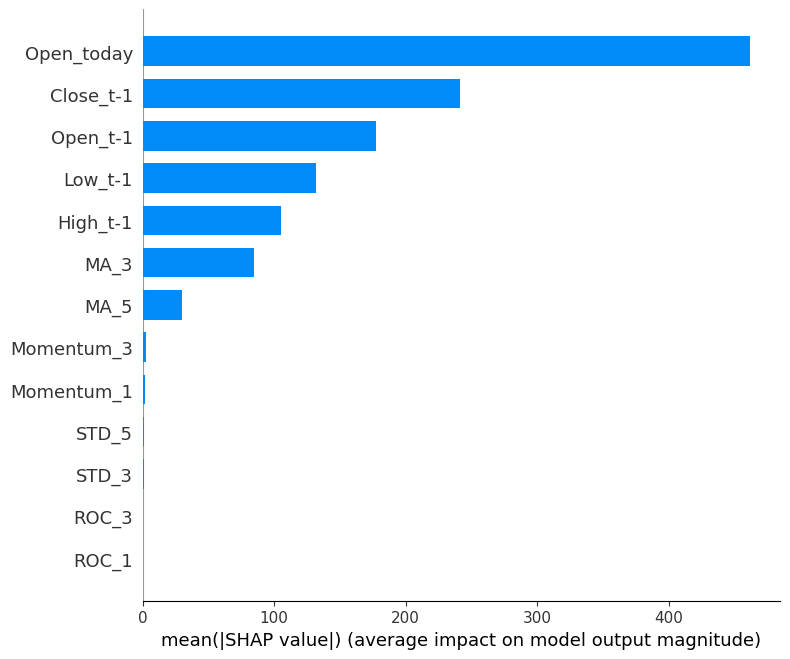

In [ ]:
shap.summary_plot(shap_values, X_full_train, plot_type="bar")  # importance global

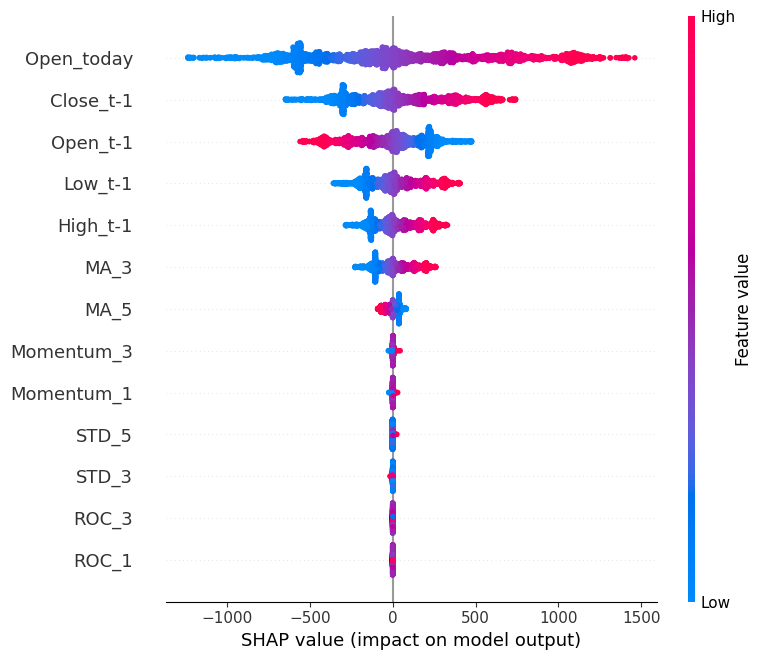

In [ ]:
shap.summary_plot(shap_values, X_full_train)  # beeswarm

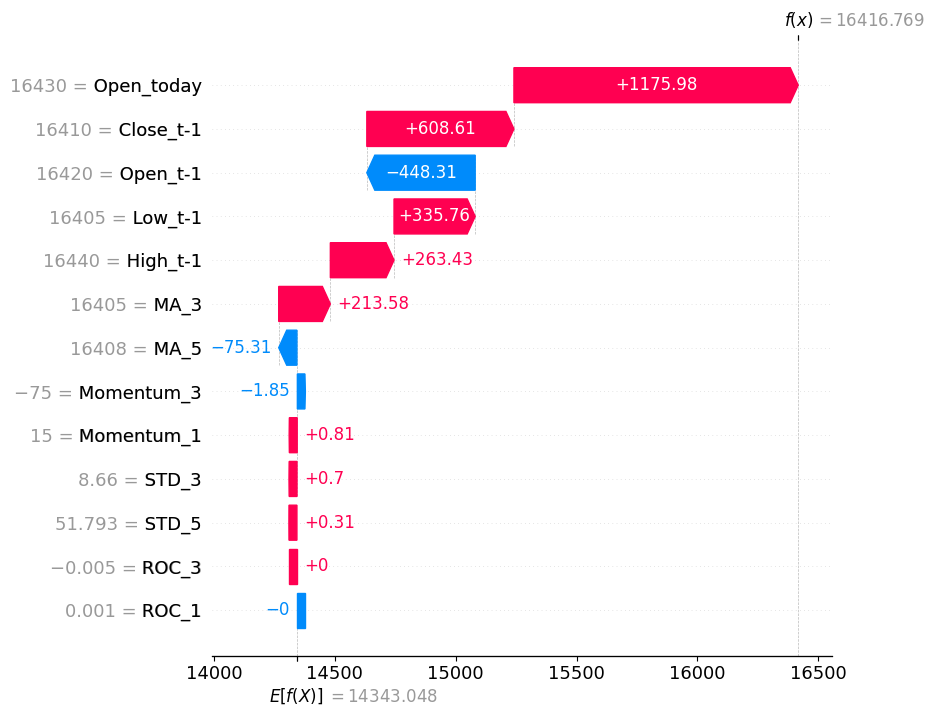

In [ ]:
shap_values_latest = explainer(X_latest)
shap.plots.waterfall(shap_values_latest[0], max_display=20)